In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
from tqdm import tqdm

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import rasterio
import rioxarray as rio
import xarray as xa

import haversine

from coralshift.processing import data
from coralshift.utils import file_ops, directories
from coralshift.dataloading import bathymetry

# Allen Coral Atlas Dataset
For the Great Barrier Reef and Torres Strait. Excellent visualisation [here](https://allencoralatlas.org/atlas/#4.55/-16.5163/147.1100).

## Load in `reefextent` and `benthic` files

**`reefextent`**

Set of shapely objects showing presence of "reef" – e.g. "a ridge of jagged rock, coral, or sand just above or below the surface of the sea." 

**`benthic`**

Set of shapely objects labelled with reef class:

| Class           	| Number of polygons 	|
|-----------------	|--------------------	|
| Coral/Algae     	| 877787             	|
| Rock            	| 766391             	|
| Rubble          	| 568041             	|
| Sand            	| 518805             	|
| Microalgal Mats 	| 27569              	|


In [63]:
reef_extent_dir = Path("/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Reef-Extent")

df_reef_extent = file_ops.check_pkl_else_read_gpkg(reef_extent_dir, "reefextent")
# map dataframe class names to values
class_vals = {"Reef": 1, "Coral/Algae": 2, "Rock": 3, "Rubble": 4, "Sand": 5, "Microalgal Mats": 6, "Seagrass": 7}
df_reef_extent['class_val'] = df_reef_extent['class'].map(class_vals)

df_reef_extent.head()

Reading /Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Reef-Extent/reefextent.pkl
reefextent read from reefextent.pkl


,class,geometry,class_val
0,Reef,"POLYGON ((146.86833 -18.02176, 146.87060 -18.0...",1
1,Reef,"POLYGON ((146.87554 -18.01891, 146.87599 -18.0...",1
2,Reef,"POLYGON ((146.37751 -17.74124, 146.37770 -17.7...",1
3,Reef,"POLYGON ((146.46510 -17.25820, 146.46469 -17.2...",1
4,Reef,"POLYGON ((146.48322 -17.25149, 146.48288 -17.2...",1


In [64]:
# N.B. takes ~10 minutes to read whole area from gpkg: faster if pickle version present
benthic_extent_dir = Path("/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Benthic-Map")

df_benthic = file_ops.check_pkl_else_read_gpkg(benthic_extent_dir, "benthic")
# map dataframe class names to values
df_benthic['class_val'] = df_benthic['class'].map(class_vals)

df_benthic.head()

Reading /Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Benthic-Map/benthic.pkl
benthic read from benthic.pkl


,class,geometry,class_val
0,Rock,"POLYGON ((146.84549 -18.00053, 146.84553 -18.0...",3
1,Rock,"POLYGON ((146.84576 -18.00116, 146.84589 -18.0...",3
2,Coral/Algae,"POLYGON ((146.84338 -18.00098, 146.84347 -18.0...",2
3,Coral/Algae,"POLYGON ((146.87401 -18.01863, 146.87414 -18.0...",2
4,Coral/Algae,"POLYGON ((146.87302 -18.01940, 146.87311 -18.0...",2


In [19]:
baseline_datasets_data_dir = Path('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/reef_baseline/RR_contemporary/tabular-data')
df_list = []
for area_file in baseline_datasets_data_dir.rglob("seaviewsurvey_reefcover_*.csv"):
	# read file and save as pkl to correct folder, with standardised formatting (e.g. save 'lng' as 'lon', speci)
	df_list.append(pd.read_csv(area_file))

### Rasterize polygons

Rasterized arrays are necessary to process the geospatial data e.g. to align different gridcells. This is carried out at
the specified resolution by `rasterio`'s built-in `features.rasterize` functionality. Default resolution is 1/12 of a
degree, since this is the size of the climate data and can be processed quickly by machine learning models to act as a 
proof-of-concept. Smaller resolutions (closer to 30m/XX degree across) are run on cloud computing servers in the separate
Google Colab notebook for regional predictions.

In [65]:
# # set resolution requirements – not sure it's useful: need more control over it and use it rarely

# def generate_filename(subject: str, suffix: str, resolution: float=1/12, horizontal_distance: float=None) -> str:
    
#     if horizontal_distance:
#         resolution = data.distance_to_degree()
#     return "_".join((subject, "{0:.3g}".format(resolution), "degree")) + file_ops.pad_suffix(suffix)

# generate_filename('coral', 'nc', 0.03)


In [68]:
# rasterise reef extent dataframe and return as xarray dataset (which is saved to an .nc file)
xa_benthic_1_12 = data.check_nc_exists_generate_raster_xa(
    dir_path = "/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed",
    filename = "reef_1_12.nc", 
    xa_ds = df_reef_extent, 
    resolution = 1/12,
    class_col = "class_val",
    xa_name = "reef_extent_1_12_degree",
    all_touched = True
)

reef_1-12.nc already exists in /Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed. No files written.


In [69]:
# rasterise coral dataframe and return as xarray dataset (which is saved to an .nc file)
xa_coral_1_12 = data.check_nc_exists_generate_raster_xa(
    dir_path = "/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed",
    filename = "coral_1_12.nc",
    xa_ds = df_benthic[df_benthic["class"] == "Coral/Algae"], 
    resolution = 1/12,
    class_col = "class_val",
    xa_name = "coral_algae_1_12_degree",
    all_touched = True
    )

coral_1-12.nc already exists in /Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed. No files written.


# Load in climate data

In [3]:
gor_monthly_dir = Path("/Volumes/MRes Drive/global_ocean_reanalysis/monthly_means/baseline_area")
gor_monthly = file_ops.load_merge_nc_files(gor_monthly_dir)
gor_monthly

<xarray.Dataset>
Dimensions:    (time: 336, latitude: 205, longitude: 157, depth: 17)
Coordinates:
  * latitude   (latitude) float32 -25.0 -24.92 -24.83 ... -8.167 -8.083 -8.0
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 29.44 34.43 40.34
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T12:00:00
  * longitude  (longitude) float32 140.0 140.1 140.2 140.2 ... 152.8 152.9 153.0
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(72, 17, 205, 157), meta=np.ndarray>
    usi        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    vsi        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(72, 17, 205, 157), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(72, 17, 205, 157), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float32 dask.array<chunksize=(72, 17, 205, 157), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [4]:
# for now, approximate all as being flat (selecting top depth layer)
gor_monthly = gor_monthly.sel(depth=0.494025)
# # could also broadcast: will figure out how best to deal with this later
# (broadcasted_gor_monthly,) = xa.broadcast(gor_monthly)

In [5]:
gor_monthly

<xarray.Dataset>
Dimensions:    (time: 336, latitude: 205, longitude: 157)
Coordinates:
  * latitude   (latitude) float32 -25.0 -24.92 -24.83 ... -8.167 -8.083 -8.0
    depth      float32 0.494
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T12:00:00
  * longitude  (longitude) float32 140.0 140.1 140.2 140.2 ... 152.8 152.9 153.0
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    thetao     (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    usi        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    vsi        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    vo         (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    uo         (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    so         (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(72, 205, 157), meta=np.ndarray>
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

The following variables returned empty arrays, and so are not plotted: ['sithick', 'siconc', 'vsi', 'usi']


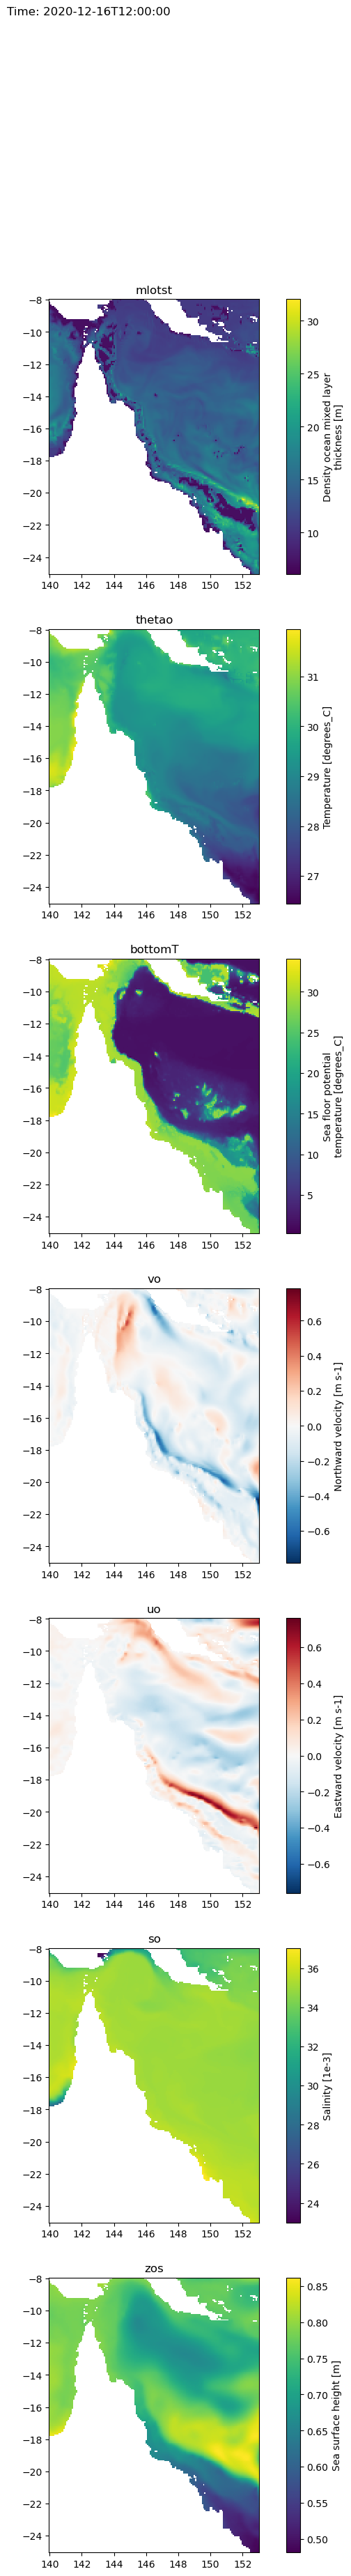

In [53]:
plot_vars_at_time(gor_monthly)

# Load in bathymetric data

In [92]:
# 30m GBR bathymetry (can visualise ETOPO later if necessary)
gbr_30_dir = Path(directories.get_volume_dir("MRes Drive"), "bathymetry/GBR_30m")
# download any missing data
bathymetry.download_30m_gbr_bathymetry(download_dest_dir=gbr_30_dir)
# fetch data
gbr_30_files = file_ops.return_list_filepaths(gbr_30_dir, ".tif")

Already exists: /Volumes/MRes Drive/bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif
Already exists: /Volumes/MRes Drive/bathymetry/GBR_30m/Great_Barrier_Reef_B_2020_30m_MSL_cog.tif
Already exists: /Volumes/MRes Drive/bathymetry/GBR_30m/Great_Barrier_Reef_C_2020_30m_MSL_cog.tif
Already exists: /Volumes/MRes Drive/bathymetry/GBR_30m/Great_Barrier_Reef_D_2020_30m_MSL_cog.tif


In [109]:
# generate dictionary of file names and arrays: {filename: xarray.DataArray, ...}
gbr_30_dict_preprocess = data.tifs_to_xa_array_dict(gbr_30_files)
# process xa_arrays (drop unnecessary coordinates) and upsample to 1/12 degree to make quicker to handle
gbr_30_dict = data.process_xa_arrays_in_dict(gbr_30_dict_preprocess, coords_to_drop=["band"])
# upsample xa_arrays in dict to 1/12 degree to make quicker to handle
bathymetry_1_12_dict = data.upsample_dict_of_xa_arrays(gbr_30_dict, resolution=1/12)

Processing xa_arrays in dictionary. Dropping ['band'], renaming dict_keys(['x', 'y']).


100%|██████████| 4/4 [00:00<00:00, 247.29it/s]


Upsampling dict_keys(['Great_Barrier_Reef_D_2020_30m_MSL_cog.tif', 'Great_Barrier_Reef_A_2020_30m_MSL_cog.tif', 'Great_Barrier_Reef_B_2020_30m_MSL_cog.tif', 'Great_Barrier_Reef_C_2020_30m_MSL_cog.tif']) from dictionary to 0.08333333333333333None.


100%|██████████| 4/4 [04:08<00:00, 62.13s/it]


In [110]:
bathymetry_1_12_dict.keys()

dict_keys(['Great_Barrier_Reef_D_2020_30m_MSL_cog_reduced_0.0833', 'Great_Barrier_Reef_A_2020_30m_MSL_cog_reduced_0.0833', 'Great_Barrier_Reef_B_2020_30m_MSL_cog_reduced_0.0833', 'Great_Barrier_Reef_C_2020_30m_MSL_cog_reduced_0.0833'])

In [127]:
def list_of_xa_arrays_from_dict(xa_dict: dict) -> list[xa.Dataset]:
    array_list = []
    for array in xa_dict.values():
        array_list.append(array)
    return array_list

def merge_dict_of_xa_arrays(xa_dict: dict, xa_da_name: str="unnamed") -> xa.Dataset:
    array_list = list_of_xa_arrays_from_dict(xa_dict)
    return xa.merge(array_list).rename(xa_da_name)


def concat_dict_of_xa_arrays(xa_dict: dict, dim: str = "combined", xa_da_name: str="unnamed") -> xa.DataArray:
    array_list = list_of_xa_arrays_from_dict(xa_dict)
    return xa.concat(array_list, dim).rename(xa_da_name)


In [112]:
merge_dict_of_xa_arrays(bathymetry_1_12_dict, "1_12_bathymetry")

<xarray.Dataset>
Dimensions:                                    (x: 217, y: 312, band: 1)
Coordinates:
  * x                                          (x) float64 142.0 142.1 ... 156.0
  * y                                          (y) float64 -28.96 ... -10.04
    spatial_ref                                int64 0
Dimensions without coordinates: band
Data variables:
    Great_Barrier_Reef_D_2020_30m_MSL_cog.tif  (band, y, x) float32 nan ... nan
    Great_Barrier_Reef_A_2020_30m_MSL_cog.tif  (band, y, x) float32 nan ... nan
    Great_Barrier_Reef_B_2020_30m_MSL_cog.tif  (band, y, x) float32 nan ... nan
    Great_Barrier_Reef_C_2020_30m_MSL_cog.tif  (band, y, x) float32 nan ... nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

In [134]:
concatted_bath = concat_dict_of_xa_arrays(bathymetry_1_12_dict, xa_da_name="1_12_bathymetry")

In [139]:
concatted_bath

<xarray.DataArray '1_12_bathymetry' (combined: 4, band: 1, y: 312, x: 217)>
array([[[[          nan,           nan,           nan, ...,
          -4064.881    , -4354.9707   , -4492.1133   ],
         [          nan,           nan,           nan, ...,
          -4298.8184   , -4352.713    , -4613.6465   ],
         [          nan,           nan,           nan, ...,
          -4397.576    , -4530.399    , -4718.295    ],
         ...,
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan]]],


       [[[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
...
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan]]],


       [[[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan]]]], dtype=float32)
Coordinates:
  * x            (x) float64 142.0 142.1 142.2 142.3 ... 155.7 155.8 155.9 156.0
  * y            (y) float64 -28.96 -28.87 -28.79 ... -10.21 -10.13 -10.04
    spatial_ref  int64 0
Dimensions without coordinates: combined, band
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

In [ ]:
# combine bathymetry tiles into xarray: nan values where data doesn't exist
xa_array_all_bathymetry = 


In [87]:
gbr_30_dict["Great_Barrier_Reef_D_2020_30m_MSL_cog.tif"]

<xarray.DataArray (band: 1, latitude: 20000, longitude: 20000)>
[400000000 values with dtype=float32]
Coordinates:
  * longitude    (longitude) float64 150.0 150.0 150.0 ... 156.0 156.0 156.0
  * latitude     (latitude) float64 -23.0 -23.0 -23.0 ... -29.0 -29.0 -29.0
    spatial_ref  int64 0
Dimensions without coordinates: band
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

### Align coral baseline, climate data, and bathymetry

In [154]:
# at 1/12 degree resolution

# reassign "class 2" (coral/algae) to values of 0 and 1 for later lstm target
xa_coral_1_12['coral_algae_1-12_degree'] = xa_coral_1_12['coral_algae_1-12_degree'].where(
    xa_coral_1_12['coral_algae_1-12_degree'] != 2, 1)
coral_climate_1_12_interped = gor_monthly.interp_like(xa_coral_1_12, method="linear")
coral_climate_1_12 = xa.merge([xa_coral_1_12,coral_climate_1_12_interped])
# broadcast coral presence with time
(coral_climate_1_12,) = xa.broadcast(coral_climate_1_12)

In [155]:
coral_climate_1_12

<xarray.Dataset>
Dimensions:                  (latitude: 187, longitude: 137, time: 336)
Coordinates:
  * latitude                 (latitude) float64 -8.755 -8.838 ... -24.17 -24.25
  * longitude                (longitude) float64 141.4 141.5 ... 152.7 152.7
    depth                    float32 0.494
  * time                     (time) datetime64[ns] 1993-01-16T12:00:00 ... 20...
Data variables: (12/13)
    spatial_ref              (latitude, longitude, time) int64 0 0 0 0 ... 0 0 0
    coral_algae_1-12_degree  (latitude, longitude, time) float64 0.0 0.0 ... 0.0
    mlotst                   (latitude, longitude, time) float32 dask.array<chunksize=(187, 137, 72), meta=np.ndarray>
    siconc                   (latitude, longitude, time) float32 dask.array<chunksize=(187, 137, 72), meta=np.ndarray>
    thetao                   (latitude, longitude, time) float32 dask.array<chunksize=(187, 137, 72), meta=np.ndarray>
    usi                      (latitude, longitude, time) float32 dask.array<chunksize=(187, 137, 72), meta=np.ndarray>
    ...                       ...
    bottomT                  (latitude, longitude, time) float32 dask.array<chunksize=(187, 137, 72), meta=np.ndarray>
    vsi                      (latitude, longitude, time) float32 dask.array<chunksize=(187, 137, 72), meta=np.ndarray>
    vo                       (latitude, longitude, time) float32 dask.array<chunksize=(187, 137, 72), meta=np.ndarray>
    uo                       (latitude, longitude, time) float32 dask.array<chunksize=(187, 137, 72), meta=np.ndarray>
    so                       (latitude, longitude, time) float32 dask.array<chunksize=(187, 137, 72), meta=np.ndarray>
    zos                      (latitude, longitude, time) float32 dask.array<chunksize=(187, 137, 72), meta=np.ndarray>

In [156]:
# save lstm-ready(ish) array to nc for passing to model
dir_path = Path("/Volumes/MRes Drive/reef_baseline/Allen_atlas/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Processed")
filename = "coral_climate_1_12.nc"
filepath = dir_path / filename

coral_1_12_climate.to_netcdf(filepath)

# Set up LSTM

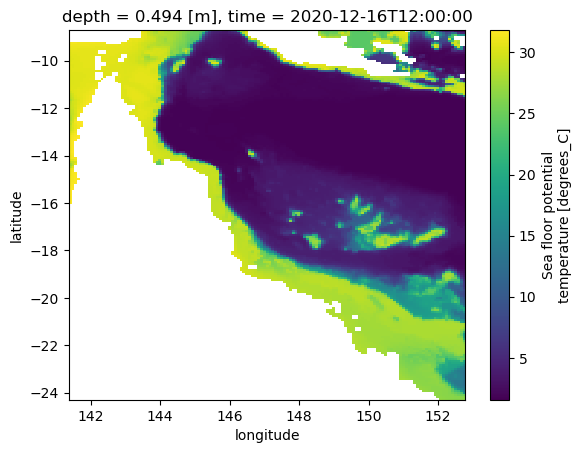

In [141]:
coral_1_12_climate["bottomT"].sel(time="2020-12-16T12:00:00.000000000").plot()

In [ ]:
lstm_array = data.xa_ds_to_3d_numpy(gor_monthly)

100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


In [ ]:
lstm_array.shape

(32185, 11, 336)

In [ ]:
# merge with coral (start with tests size)
# merge with bathymetry
# throw this into an lstm
# visualise weather data
# write up/plot other reef baselines

In [ ]:
xa_timeseries = xa.merge([broadcasted_no_ice,xa_coral])
xa_timeseries

NameError: name 'xa_coral' is not defined

In [ ]:
(lstm_xarray,) = xa.broadcast(xa_timeseries)
lstm_xarray

<xarray.Dataset>
Dimensions:        (depth: 17, latitude: 272, time: 336, longitude: 198)
Coordinates:
  * depth          (depth) float32 0.494 1.541 2.646 3.819 ... 29.44 34.43 40.34
  * latitude       (latitude) float64 -24.25 -24.17 -24.09 ... -8.838 -8.755
  * time           (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T1...
  * longitude      (longitude) float64 141.4 141.5 141.6 ... 152.6 152.7 152.7
    spatial_ref    int64 0
Data variables:
    mlotst         (depth, latitude, time, longitude) float32 nan nan ... nan
    vo             (depth, latitude, time, longitude) float32 nan nan ... nan
    thetao         (depth, latitude, time, longitude) float32 nan nan ... nan
    uo             (depth, latitude, time, longitude) float32 nan nan ... nan
    bottomT        (depth, latitude, time, longitude) float32 nan nan ... nan
    so             (depth, latitude, time, longitude) float32 nan nan ... nan
    zos            (depth, latitude, time, longitude) float32 nan nan ... nan
    limited coral  (depth, latitude, time, longitude) float64 0.0 0.0 ... 0.0
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [ ]:
lstm_interped = broadcasted_no_ice.interp_like(xa_coral, method="linear")
lstm_combined = xa.merge([xa_coral,lstm_interped])
(broadcasted_no_ice,) = xa.broadcast(lstm_combined)

In [ ]:
xarray_coords_limits(broadcasted_no_ice)

[(-24.254801096000108, -8.754801096),
 (141.41095048, 152.74428381333462),
 (7.271856e+17, 1.60812e+18),
 (0.49402499198913574, 40.344051361083984)]

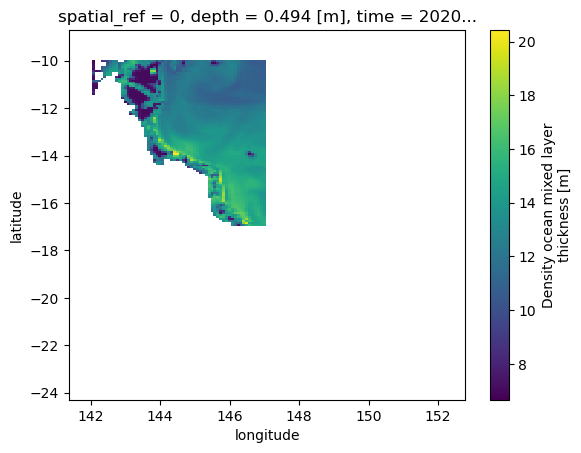

In [ ]:
broadcasted_no_ice["mlotst"].sel(depth=0.494025,time='2020-12-16T12:00:00.000000000').plot()

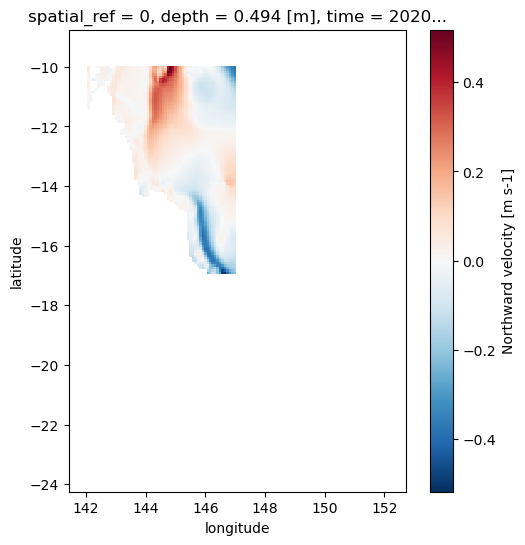

In [ ]:
f, lstm_ax = plt.subplots(figsize=[6,6])

# lstm_xarray["mlotst"].sel(depth=lstm_xarray.depth.values[0], time=lstm_xarray.time.values[0]).plot(ax=lstm_ax)
broadcasted_no_ice["vo"].sel(depth=broadcasted_no_ice.depth.values[0], time=broadcasted_no_ice.time.values[-1]).plot(
    ax=lstm_ax)
[ylims,xlims,_,_] = xarray_coords_limits(broadcasted_no_ice)

lstm_ax.set_xlim(xlims)
lstm_ax.set_ylim(ylims)
lstm_ax.set_aspect("equal")

In [ ]:
flat_vars = ["zos","mlotst","bottomT","sithick","siconc","usi","vsi"]

month_datasets = [data_dict[month][flat_vars] for month in sorted(data_dict.keys())]
flat_vars_ds = xa.concat(month_datasets, dim='time')

In [ ]:
# f, ax_coral = plt.subplots()

cipher = {"Reef": 1, "Coral/Algae": 2, "Rock": 3, "Rubble": 4, "Sand": 5, "Microalgal Mats": 6, "Seagrass": 7}

df_benthic['class_val'] = df_benthic['class'].map(cipher)
#RERUN ONLY IF NECESSARY
raster_benthic_coral, (xmin, ymin, xmax, ymax) = rasterize_shapely_df(df_benthic[df_benthic["class"] == "Coral/Algae"], "class_val", resolution=1/12)
# TODO: include naming of xa
xa_coral = xa_array_from_raster(raster_benthic_coral, (ymin,ymax), (xmin,xmax), resolution=1/12)
# xa_coral.plot(ax=ax_coral)
# ax_coral.axis('equal')

100%|██████████| 877787/877787 [56:34<00:00, 258.61it/s]  


In [ ]:
flat_vars_ds

<xarray.Dataset>
Dimensions:      (time: 12, latitude: 2041, longitude: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1993-01-16T12:00:00 ... 1993-12-16T12:...
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude     (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
    spatial_ref  int64 0
Data variables:
    zos          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    mlotst       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    bottomT      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    sithick      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    siconc       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    usi          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    vsi          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/16)
    CDI:                           Climate Data Interface version 1.9.3 (http...
    source:                        MERCATOR GLORYS12V1
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    CDO:                           Climate Data Operators version 1.9.3 (http...
    title:                         Monthly climatology fields for product GLO...
    dataset:                       global-reanalysis-phy-001-030-monthly-clim...

In [ ]:
merged = xa.merge([flat_vars_ds,xa_coral])
merged

<xarray.Dataset>
Dimensions:              (time: 12, longitude: 4457, latitude: 2228)
Coordinates:
  * time                 (time) datetime64[ns] 1993-01-16T12:00:00 ... 1993-1...
  * longitude            (longitude) float64 -180.0 -179.9 ... 179.8 179.9
  * latitude             (latitude) float64 -80.0 -79.92 -79.83 ... 89.92 90.0
    spatial_ref          int64 0
Data variables:
    zos                  (time, latitude, longitude) float32 nan nan ... nan nan
    mlotst               (time, latitude, longitude) float32 nan nan ... nan nan
    bottomT              (time, latitude, longitude) float32 nan nan ... nan nan
    sithick              (time, latitude, longitude) float32 nan nan ... nan nan
    siconc               (time, latitude, longitude) float32 nan nan ... nan nan
    usi                  (time, latitude, longitude) float32 nan nan ... nan nan
    vsi                  (time, latitude, longitude) float32 nan nan ... nan nan
    limited reef extent  (latitude, longitude) float64 nan nan nan ... nan nan
Attributes: (12/16)
    CDI:                           Climate Data Interface version 1.9.3 (http...
    source:                        MERCATOR GLORYS12V1
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    CDO:                           Climate Data Operators version 1.9.3 (http...
    title:                         Monthly climatology fields for product GLO...
    dataset:                       global-reanalysis-phy-001-030-monthly-clim...

In [ ]:
xa_coral = xa_coral.rename("limited coral")

In [ ]:
xa_coral

<xarray.DataArray 'limited coral' (latitude: 187, longitude: 137)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * latitude     (latitude) float64 -8.755 -8.838 -8.921 ... -24.17 -24.25
  * longitude    (longitude) float64 141.4 141.5 141.6 ... 152.6 152.7 152.7
    spatial_ref  int64 0

In [ ]:
xarray_coords_limits(flat_vars_ds)

[(7.271856e+17, 7.560432e+17), (-80.0, 90.0), (-180.0, 179.9166717529297)]

In [ ]:
xa_xa_coral

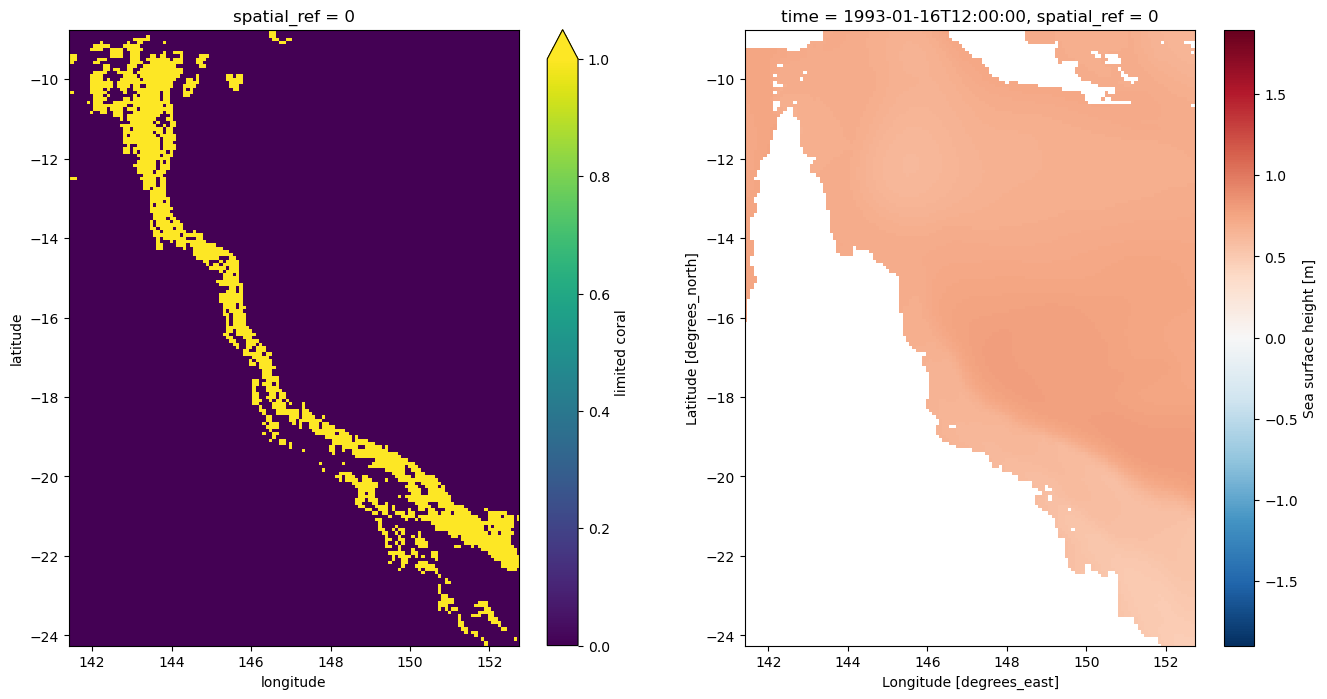

In [ ]:
f,ax_all_coral = plt.subplots(1,2, figsize=[16,8])
[ylims,xlims] = xarray_coords_limits(xa_coral)

xa_coral.plot(ax=ax_all_coral[0], vmin=0, vmax=1)
flat_vars_ds["zos"][0].plot(ax=ax_all_coral[1])

for ax in ax_all_coral:
    ax.set_aspect("equal")
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)

In [ ]:
interped = flat_vars_ds.interp_like(xa_coral, method="linear")
combined = xa.merge([xa_coral,interped])
(broadcasted,) = xa.broadcast(combined)

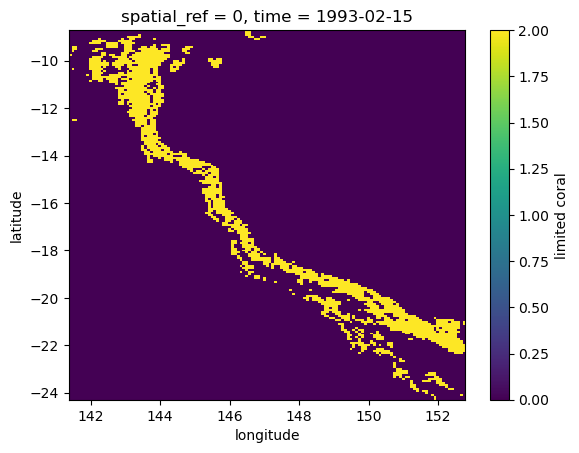

In [ ]:
broadcasted["limited coral"].sel(time=broadcasted.time[1].values).plot()

In [ ]:
list(broadcasted.data_vars)

['limited coral',
 'zos',
 'mlotst',
 'bottomT',
 'sithick',
 'siconc',
 'usi',
 'vsi']

In [ ]:
data_vars = list(combined.data_vars)
num_vars = len(data_vars)

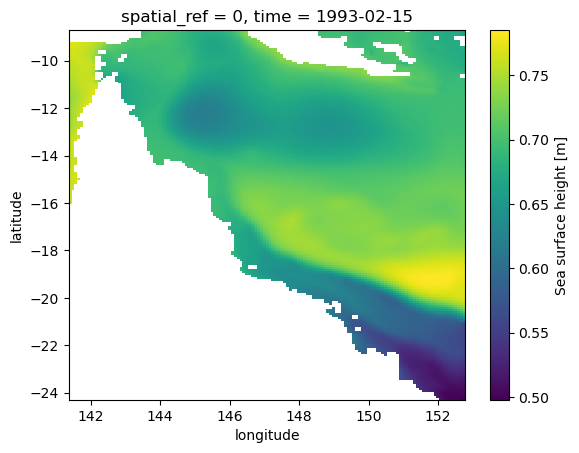

In [ ]:
# any("time" for el in list(combined[data_vars[1]].coords))
# combined[data_vars[1]][0].plot()
broadcasted[data_vars[1]].sel(time=broadcasted.time[1].values).plot()

In [ ]:
broadcasted.time

<xarray.DataArray 'time' (time: 12)>
array(['1993-01-16T12:00:00.000000000', '1993-02-15T00:00:00.000000000',
       '1993-03-16T12:00:00.000000000', '1993-04-16T00:00:00.000000000',
       '1993-05-16T12:00:00.000000000', '1993-06-16T00:00:00.000000000',
       '1993-07-16T12:00:00.000000000', '1993-08-16T12:00:00.000000000',
       '1993-09-16T00:00:00.000000000', '1993-10-16T12:00:00.000000000',
       '1993-11-16T00:00:00.000000000', '1993-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 1993-01-16T12:00:00 ... 1993-12-16T12:...
Attributes:
    standard_name:  time
    long_name:      Time (hours since 1950-01-01)
    axis:           T

In [ ]:
f,ax=plt.subplots(figsize=[6,6])
broadcasted_no_ice["limited coral"].sel(
        time=broadcasted_no_ice.time[-1].values, depth=broadcasted_no_ice.depth.values[0]).plot(ax=ax)

ax.set_xlim(145,145.6)
ax.set_ylim(-15,-14)

NameError: name 'plt' is not defined

In [ ]:
time = xa.cftime_range(start='2022-01-01', end='2022-01-05', freq='D')

# create lat and lon coordinates
lat = np.linspace(-90, 90, 5)
lon = np.linspace(-180, 180, 5)

# create random data for each coordinate
# create random data for each variable and coordinate
data1 = np.random.rand(len(time), len(lat), len(lon))
data2 = np.random.rand(len(time), len(lat), len(lon))
data3 = np.random.rand(len(time), len(lat), len(lon))

# create xarray dataset with time, lat, and lon as coordinates
ds = xa.Dataset({'data1': (['time', 'lat', 'lon'], data1),
                 'data2': (['time', 'lat', 'lon'], data2),
                 'data3': (['time', 'lat', 'lon'], data3)},
                coords={'time': time,
                        'lat': lat,
                        'lon': lon})


# stacked.transpose('time','points').as_numpy()

# np.shape(stacked['data1'].transpose('time','points').to_numpy())

def stacking(ds):
    stacked = ds.stack(points=('lat', 'lon'))

    vars_list = list(ds.variables)
    stack= stacked[vars_list[0]].to_numpy()

    for d in vars_list[1:]:
        vals = stacked[d].transpose('time','points').to_numpy()
        stack = np.stack([stack, vals], axis=1)

    return stack

stacking(ds)

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (time: 5, lat: 5, lon: 5)
Coordinates:
  * time     (time) object 2022-01-01 00:00:00 ... 2022-01-05 00:00:00
  * lat      (lat) float64 -90.0 -45.0 0.0 45.0 90.0
  * lon      (lon) float64 -180.0 -90.0 0.0 90.0 180.0
Data variables:
    data1    (time, lat, lon) float64 0.9025 0.3111 0.3582 ... 0.1516 0.8246
    data2    (time, lat, lon) float64 0.05484 0.4312 0.8898 ... 0.1897 0.03269
    data3    (time, lat, lon) float64 0.3408 0.104 0.2043 ... 0.06129 0.5198

In [ ]:
stacked = ds.stack(points=('lat', 'lon'))
num_timesteps = len(ds.time)
stacked

<xarray.Dataset>
Dimensions:  (time: 5, points: 25)
Coordinates:
  * time     (time) object 2022-01-01 00:00:00 ... 2022-01-05 00:00:00
  * points   (points) object MultiIndex
  * lat      (points) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * lon      (points) float64 -180.0 -90.0 0.0 90.0 ... -90.0 0.0 90.0 180.0
Data variables:
    data1    (time, points) float64 0.9025 0.3111 0.3582 ... 0.36 0.1516 0.8246
    data2    (time, points) float64 0.05484 0.4312 0.8898 ... 0.1897 0.03269
    data3    (time, points) float64 0.3408 0.104 0.2043 ... 0.06129 0.5198

In [ ]:
# stacked.transpose('time','points').as_numpy()

# np.shape(stacked['data1'].transpose('time','points').to_numpy())

def stacking(ds):
    stacked = ds.stack(points=('lat', 'lon'))

    vars_list = list(ds.variables)
    stack= stacked[vars_list[0]].to_numpy()

    for d in vars_list[1:]:
        vals = stacked[d].transpose('time','points').to_numpy()
        stack = np.stack([stack, vals], axis=1)

    return stack

stacking(ds)

ValueError: all input arrays must have the same shape

ValueError: Dimensions {'points'} do not exist. Expected one or more of ('time', 'lat', 'lon')

In [ ]:
reshaped = stacked.transpose('points', 'time').values
reshaped


<bound method Mapping.values of <xarray.Dataset>
Dimensions:  (time: 5, points: 25)
Coordinates:
  * time     (time) object 2022-01-01 00:00:00 ... 2022-01-05 00:00:00
  * points   (points) object MultiIndex
  * lat      (points) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * lon      (points) float64 -180.0 -90.0 0.0 90.0 ... -90.0 0.0 90.0 180.0
Data variables:
    data1    (points, time) float64 0.9025 0.3547 0.1647 ... 0.5746 0.8246
    data2    (points, time) float64 0.05484 0.1243 0.1361 ... 0.8891 0.03269
    data3    (points, time) float64 0.3408 0.2856 0.1865 ... 0.8724 0.644 0.5198>

In [ ]:
data = broadcasted_no_ice.sel(depth=broadcasted_no_ice.depth.values[0])

stacked = data.stack(points=['latitude', 'longitude', 'time'])

In [ ]:
stacked.indexes["points"][0]

AttributeError: 'tuple' object has no attribute 'values'

In [ ]:
data.to_dataframe("out").unstack()

ValueError: dim_order out does not match the set of dimensions of this Dataset: ['latitude', 'longitude', 'time']

In [ ]:
stacked.indexes["points"]

MultiIndex([(       -8.754801096,       141.41095048, '1993-01-16 12:00:00'),
            (       -8.754801096,       141.41095048, '1993-02-15 00:00:00'),
            (       -8.754801096,       141.41095048, '1993-03-16 12:00:00'),
            (       -8.754801096,       141.41095048, '1993-04-16 00:00:00'),
            (       -8.754801096,       141.41095048, '1993-05-16 12:00:00'),
            (       -8.754801096,       141.41095048, '1993-06-16 00:00:00'),
            (       -8.754801096,       141.41095048, '1993-07-16 12:00:00'),
            (       -8.754801096,       141.41095048, '1993-08-16 12:00:00'),
            (       -8.754801096,       141.41095048, '1993-09-16 00:00:00'),
            (       -8.754801096,       141.41095048, '1993-10-16 12:00:00'),
            ...
            (-24.254801096000108, 152.74428381333462, '2020-03-16 12:00:00'),
            (-24.254801096000108, 152.74428381333462, '2020-04-16 00:00:00'),
            (-24.254801096000108, 152.7442838133

In [ ]:
numpy_array = stacked.values

In [ ]:
numpy_array

<bound method Mapping.values of <xarray.Dataset>
Dimensions:        (points: 8607984)
Coordinates:
    spatial_ref    int64 0
    depth          float32 0.494
  * points         (points) object MultiIndex
  * latitude       (points) float64 -8.755 -8.755 -8.755 ... -24.25 -24.25
  * longitude      (points) float64 141.4 141.4 141.4 ... 152.7 152.7 152.7
  * time           (points) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16...
Data variables:
    limited coral  (points) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mlotst         (points) float64 nan nan nan nan nan ... nan nan nan nan nan
    vo             (points) float64 nan nan nan nan nan ... nan nan nan nan nan
    thetao         (points) float64 nan nan nan nan nan ... nan nan nan nan nan
    uo             (points) float64 nan nan nan nan nan ... nan nan nan nan nan
    bottomT        (points) float64 nan nan nan nan nan ... nan nan nan nan nan
    so             (points) float64 nan nan nan nan nan ... nan nan

8it [00:00, 11.88it/s]


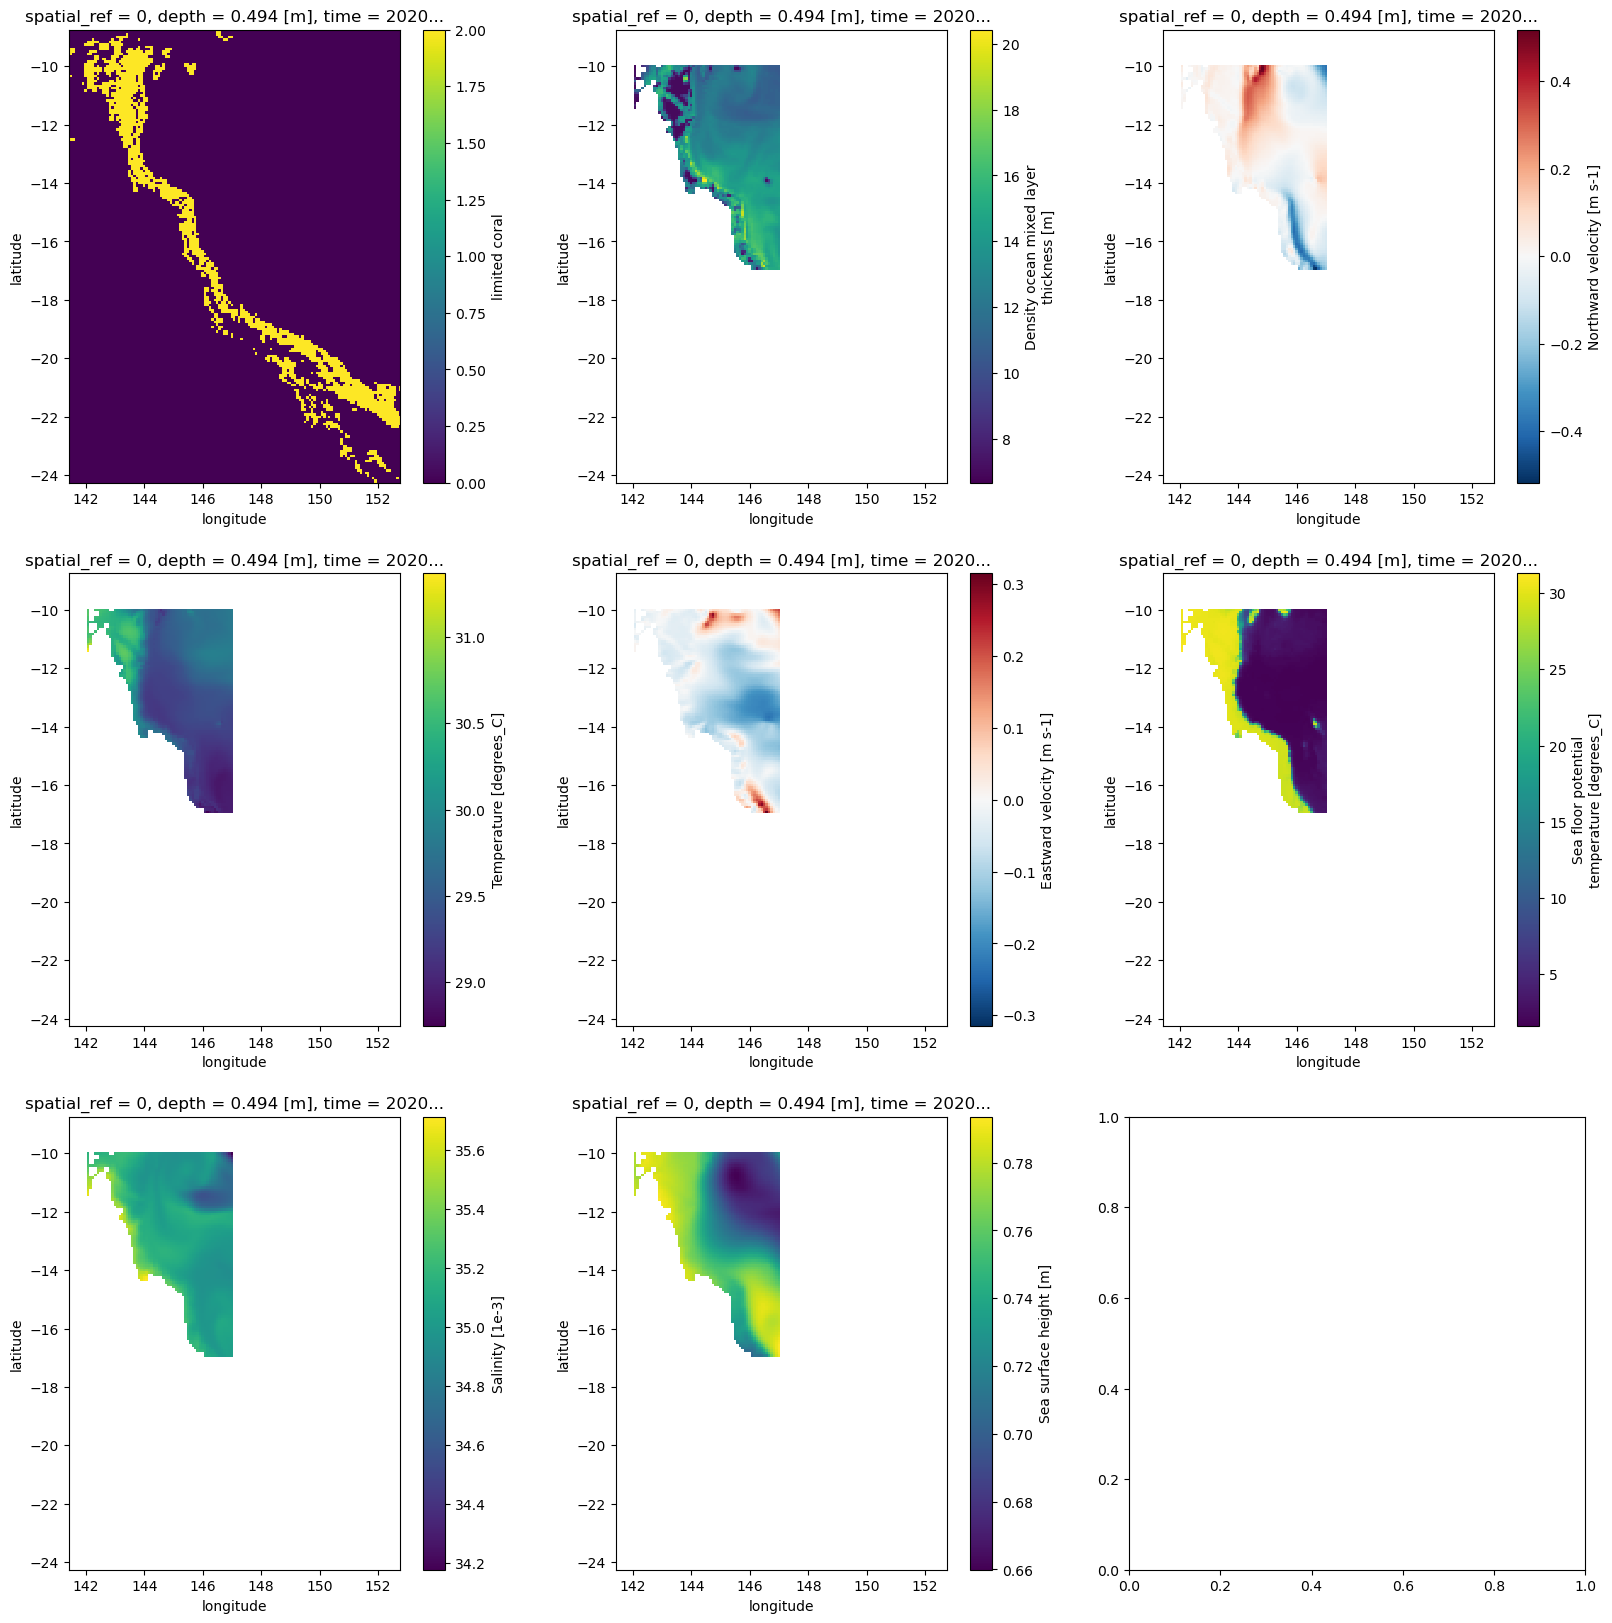

In [ ]:
# change this so it plots all variables in an xarray automatically
data_vars = list(broadcasted_no_ice.data_vars)
num_vars = len(data_vars)

num_cols = int(np.ceil(num_vars/3))

f, ax_all = plt.subplots(num_cols, num_cols, figsize=[20,20])
ax_all = ax_all.ravel()

for i, var in tqdm(enumerate(data_vars)):
    # if contains "time" (i.e. not just 2d), plot most recent
    # if any("time" for el in list(combined[data_vars[1]].coords)):
        # combined[var][-1].plot(ax=ax_all[i])
    # else:
    broadcasted_no_ice[var].sel(
        time=broadcasted_no_ice.time[-1].values, depth=broadcasted_no_ice.depth.values[0]).plot(ax=ax_all[i])
    ax_all[i].set_aspect("equal")
    ax_all[i].set_xlim(xlims)
    ax_all[i].set_ylim(ylims)
    # # coords zoomed on coastal area
    # ax_all[i].set_xlim(145,145.6)
    # ax_all[i].set_ylim(-15,-14)

In [ ]:
broadcasted_no_ice["limited coral"].sel(time=broadcasted_no_ice.time[-1].values, depth=broadcasted_no_ice.depth.values[0])

<xarray.DataArray 'limited coral' (latitude: 187, longitude: 137)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * latitude     (latitude) float64 -8.755 -8.838 -8.921 ... -24.17 -24.25
  * longitude    (longitude) float64 141.4 141.5 141.6 ... 152.6 152.7 152.7
    spatial_ref  int64 0
    depth        float32 0.494
    time         datetime64[ns] 2020-12-16T12:00:00

In [ ]:
interped = flat_vars_ds.interp_like(xa_coral, method="zero")
interped = xa.merge([xa_coral, interped])

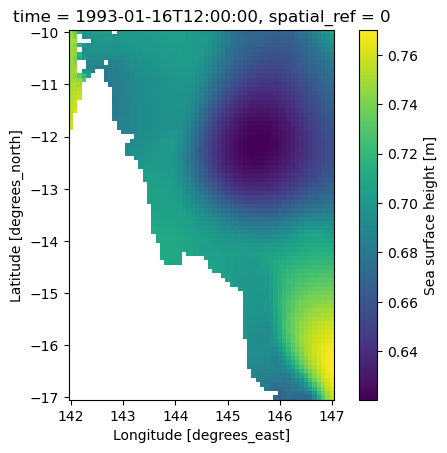

In [ ]:
f,test_ax = plt.subplots()

climate_interest = flat_vars_ds.sel(latitude=slice(-17,-10), longitude=slice(142,147))
climate_interest["zos"][0].plot(ax=test_ax)
test_ax.set_aspect('equal')
# xa_coral.plot(ax=test_ax)
# climate_interest

(-17.0, -10.0)

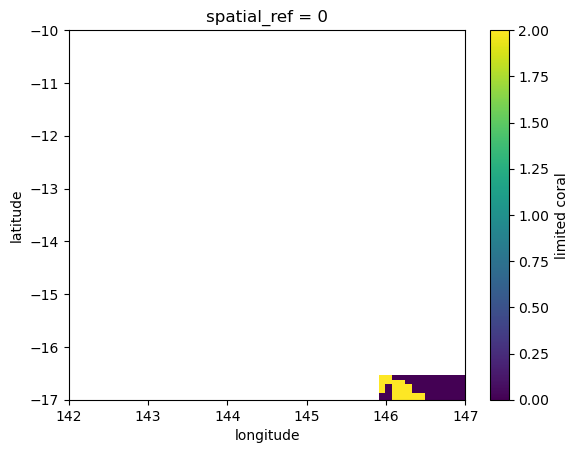

In [ ]:
f,coral_ax = plt.subplots()

xa_coral.plot(ax=coral_ax)
coral_ax.set_xlim(142,147)
coral_ax.set_ylim(-17,-10)
# xa_coral.plot(ax=test_ax)
# climate_interest

(-17.0, -16.5)

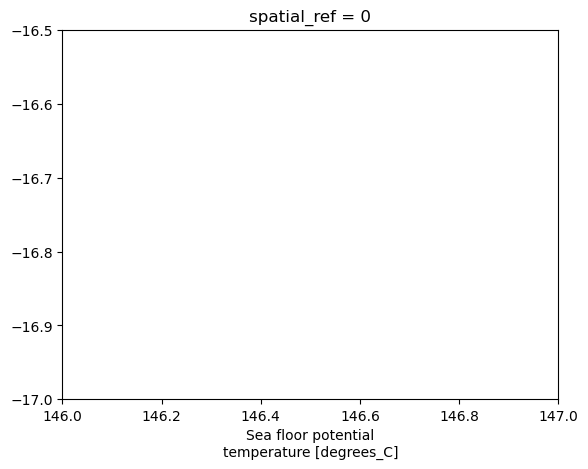

In [ ]:
f, ax_interped = plt.subplots()
# interped["limited coral"].plot(ax=ax_interped)
interped["bottomT"].plot(ax=ax_interped)

ax_interped.set_xlim(146,147)
ax_interped.set_ylim(-17,-16.5)


(-17.0, -16.5)

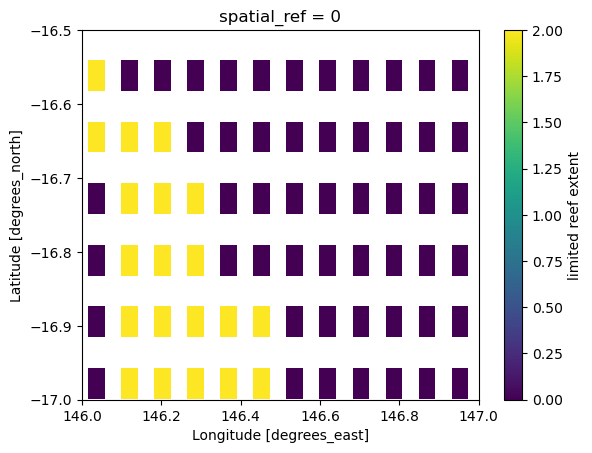

In [ ]:
f, ax_lim = plt.subplots()
merged["limited reef extent"].plot(ax=ax_lim)
ax_lim.set_xlim(146,147)
ax_lim.set_ylim(-17,-16.5)

In [ ]:
cipher = {"Reef": 1, "Coral/Algae": 2, "Rock": 3, "Rubble": 4, "Sand": 5, "Microalgal Mats": 6, "Seagrass": 7}

# df_benthic['class_val'] = df_benthic['class'].map(cipher)
df_reef_extent['class_val'] = df_reef_extent['class'].map(cipher)
df_reef_extent.head()

,class,geometry,class_val
0,Reef,"POLYGON ((146.86833 -18.02176, 146.87060 -18.0...",1
1,Reef,"POLYGON ((146.87554 -18.01891, 146.87599 -18.0...",1
2,Reef,"POLYGON ((146.37751 -17.74124, 146.37770 -17.7...",1
3,Reef,"POLYGON ((146.46510 -17.25820, 146.46469 -17.2...",1
4,Reef,"POLYGON ((146.48322 -17.25149, 146.48288 -17.2...",1


<Axes: >

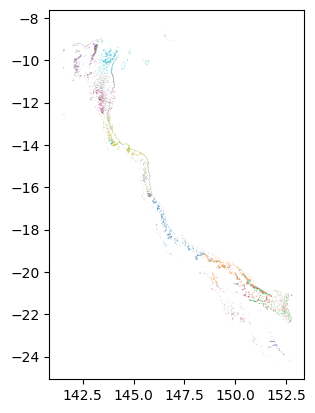

In [ ]:
fig, ax = plt.subplots()
df_reef_extent.plot(ax=ax, column="geometry", label="class")

In [ ]:
# def haversine(lats: tuple[float], lons: tuple[float]):
#     # earth radius in km (~at equator)
#     R = 6356.7523 # this is in miles.

#     dLat = np.radians(lats[1] - lats[0])
#     dLon = np.radians(lons[1] - lats[0])
#     lat1 = np.radians(lats[0])
#     lat2 = np.radians(lats[1])

#     a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
#     c = 2*np.arcsin(np.sqrt(a))

#     return R * c
# haversine((0,0.001), (0,0))

In [ ]:
# generate lat lon arrays by specifying start and end lat/lons, and resolution (in m or degrees)

# haversine.haversine((0,0.001), (0,0), unit=haversine.Unit.METERS)
haversine.inverse_haversine((-12,144), 200, direction=haversine.Direction.SOUTH, unit=haversine.Unit.METERS)

(-12.001798640727449, 144.0)

In [ ]:
# native resolution (~3.7m)
# raster_reef_extent_highres, (xmin, ymin, xmax, ymax) = rasterize_shapely_df(df_reef_extent[:10], "class_val", resolution=0.000033274853457)
# xa_reef_extent_highres = xa_array_from_raster(raster_reef_extent_highres, (ymin,ymax), (xmin,xmax), resolution=0.000033274853457)
# xa_reef_extent_highres[:4].plot()

100%|██████████| 27381/27381 [00:34<00:00, 803.66it/s]


NameError: name 'lats_list' is not defined

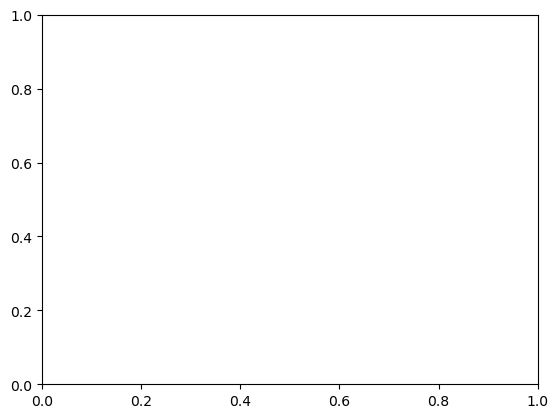

In [ ]:
f, ax_reef_extent = plt.subplots()
raster_reef_extent, (xmin, ymin, xmax, ymax) = rasterize_shapely_df(df_reef_extent[:], "class_val", resolution=1/12)
xa_reef_extent = xa_array_from_raster(raster_reef_extent, (ymin,ymax), (xmin,xmax), resolution=1/12)
xa_reef_extent.plot(ax=ax_reef_extent)
ax_reef_extent.axis('equal')

100%|██████████| 27381/27381 [01:39<00:00, 275.46it/s]


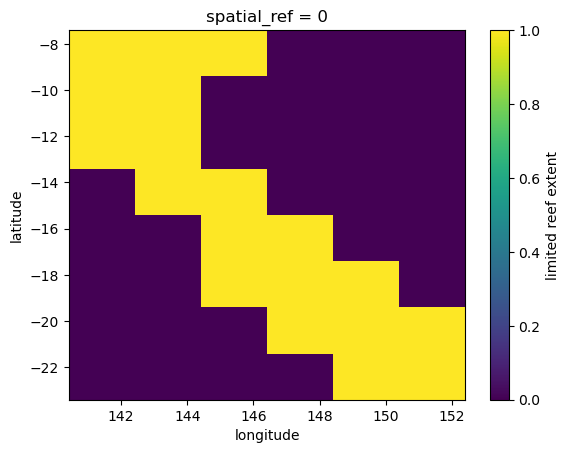

In [ ]:
toy_reef_extent, (xmin, ymin, xmax, ymax) = rasterize_shapely_df(df_reef_extent[:], "class_val", resolution=2)
xa_toy_reef_extent = xa_array_from_raster(toy_reef_extent, (ymin,ymax), (xmin,xmax), resolution=2)
xa_toy_reef_extent.plot()

In [ ]:
from coralshift.utils import directories, file_ops
from coralshift.dataloading import bathymetry
from coralshift.processing import data
# 30m GBR bathymetry (can visualise ETOPO later if necessary)
gbr_30_dir = Path(directories.get_volume_dir("MRes Drive"), "bathymetry/GBR_30m")

# download missing data
bathymetry.download_30m_gbr_bathymetry(download_dest_dir=gbr_30_dir)

# fetch data
gbr_30_files = file_ops.return_list_filepaths(gbr_30_dir, ".tif")
# generate dictionary of file names and arrays: {filename: xarray.DataArray, ...}
gbr_30_dict_preprocess = data.tifs_to_xa_array_dict(gbr_30_files)
# process xa_arrays
gbr_30_dict = data.process_xa_arrays_in_dict(gbr_30_dict_preprocess, coords_to_drop=["band"])

Already exists: /Volumes/MRes Drive/bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif
Already exists: /Volumes/MRes Drive/bathymetry/GBR_30m/Great_Barrier_Reef_B_2020_30m_MSL_cog.tif
Already exists: /Volumes/MRes Drive/bathymetry/GBR_30m/Great_Barrier_Reef_C_2020_30m_MSL_cog.tif
Already exists: /Volumes/MRes Drive/bathymetry/GBR_30m/Great_Barrier_Reef_D_2020_30m_MSL_cog.tif


In [ ]:
gbr_30_dict["Great_Barrier_Reef_A_2020_30m_MSL_cog.tif"]

<xarray.DataArray (band: 1, latitude: 23333, longitude: 16666)>
array([[[   -7.541241,    -7.70549 , ..., -2375.686   , -2376.507   ],
        [   -8.608861,    -8.773109, ..., -2374.7825  , -2376.425   ],
        ...,
        [   43.62238 ,    45.018497, ..., -1532.1022  , -1532.1842  ],
        [   45.10062 ,    46.16824 , ..., -1532.1022  , -1532.1842  ]]],
      dtype=float32)
Coordinates:
  * longitude    (longitude) float64 142.0 142.0 142.0 ... 147.0 147.0 147.0
  * latitude     (latitude) float64 -10.0 -10.0 -10.0 ... -17.0 -17.0 -17.0
    spatial_ref  int64 0
Dimensions without coordinates: band
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
# haversine.inverse_haversine((-13.5,145.5), 3.7, direction=haversine.Direction.SOUTH, unit=haversine.Unit.METERS)
haversine.haversine((0,0), (0,0.000033274853457), unit=haversine.Unit.METERS) # basically the same, wherever on world

3.6999999999101645

In [ ]:
5/16666

0.0003000120004800192

In [ ]:
np.sqrt(len(df_reef_extent)*3.7)

318.291847209444

In [ ]:
bath_upsampled_array = data.upsample_xa_array(gbr_30_dict["Great_Barrier_Reef_A_2020_30m_MSL_cog.tif"]).rename("bathymetry")
coords_cipher = {"x": "longitude", "y": "latitude"}
bathymetry = bath_upsampled_array.rename(coords_cipher)
bathymetry

<xarray.DataArray 'bathymetry' (band: 1, latitude: 700, longitude: 500)>
array([[[  -11.64747 ,   -11.318972,   -11.565346, ..., -2358.029   ,
         -2367.0627  , -2366.0774  ],
        [  -10.826224,   -11.154723,   -11.154723, ..., -2348.667   ,
         -2354.662   , -2361.232   ],
        [  -11.565346,   -11.236847,   -11.154723, ..., -2344.7249  ,
         -2343.5752  , -2351.7876  ],
        ...,
        [   41.65139 ,    44.19725 ,    44.607872, ..., -1525.5321  ,
         -1531.2809  , -1536.3726  ],
        [   41.65139 ,    43.45813 ,    50.76722 , ..., -1522.9042  ,
         -1528.735   , -1533.6625  ],
        [   46.00399 ,    45.757618,    45.511246, ..., -1518.8801  ,
         -1528.735   , -1531.9379  ]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float64 142.0 142.0 142.0 ... 147.0 147.0 147.0
  * latitude     (latitude) float64 -10.01 -10.02 -10.03 ... -16.98 -16.99 -17.0
    spatial_ref  int64 0
Dimensions without coordinates: band
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

In [ ]:
interped = xa_toy_reef_extent.interp_like(bathymetry, method="zero").rename("reef")
interped

<xarray.DataArray 'reef' (latitude: 700, longitude: 500)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])
Coordinates:
    spatial_ref  int64 0
  * latitude     (latitude) float64 -10.01 -10.02 -10.03 ... -16.98 -16.99 -17.0
  * longitude    (longitude) float64 142.0 142.0 142.0 ... 147.0 147.0 147.0

In [ ]:
merged = xa.merge([interped, bathymetry])
merged

<xarray.Dataset>
Dimensions:      (latitude: 700, longitude: 500, band: 1)
Coordinates:
    spatial_ref  int64 0
  * latitude     (latitude) float64 -10.01 -10.02 -10.03 ... -16.98 -16.99 -17.0
  * longitude    (longitude) float64 142.0 142.0 142.0 ... 147.0 147.0 147.0
Dimensions without coordinates: band
Data variables:
    reef         (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    bathymetry   (band, latitude, longitude) float32 -11.65 ... -1.532e+03

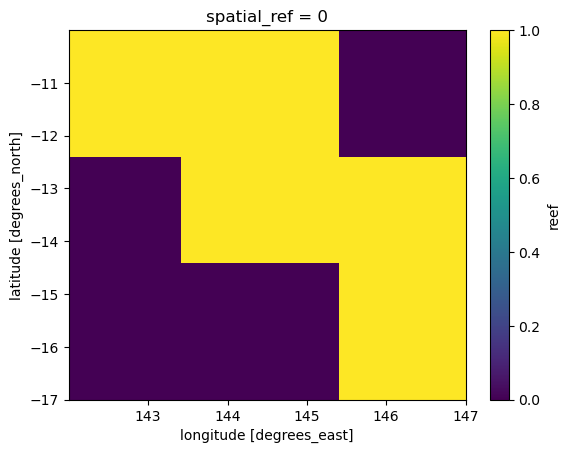

In [ ]:
# merged["bathymetry"].plot(vmin=-100,vmax=100)
merged["reef"].plot(vmin=0,vmax=1)

In [ ]:
d1_x_max, d1_y_max = 23,10
num_x, num_y = 2, 2

d1 = np.ones((num_x,num_y))
d1_x = np.linspace(-10,d1_x_max,num_x)
d1_y = np.linspace(0,d1_y_max,num_y)
d2 = np.zeros((100,100))
d2_coords = np.arange(0,100,1)

da1 = xa.DataArray(data=d1, dims=["x","y"], coords={"x":d1_x,"y":d1_y}, name="da1")
da2 = xa.DataArray(data=d2, dims=["x","y"], coords={"x":d2_coords,"y":d2_coords}, name="da2")

da1_interp = da1.interp_like(da2)

merged = xa.merge([da2, da1_interp])
merged

# merged["da1"].plot()

<xarray.Dataset>
Dimensions:  (x: 100, y: 100)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    da2      (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    da1      (x, y) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan nan

In [ ]:
list(gbr_30_dict.keys())[0]

'Great_Barrier_Reef_D_2020_30m_MSL_cog.tif'

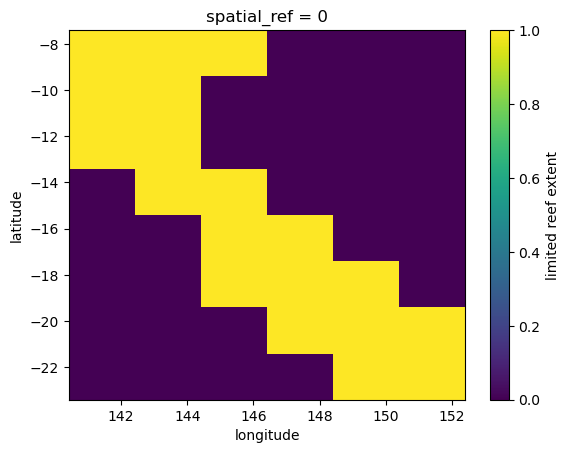

In [ ]:
raster_benthic = rasterize_shapely_df(df_benthic[df_benthic["class_val"] == 2], "class_val", resolution=1)

100%|██████████| 877787/877787 [23:37<00:00, 619.29it/s]  


In [ ]:
# np.shape(raster)
sum(sum(raster_benthic))

3092.0

In [ ]:
# generate xa_array of raster


1707.0

In [ ]:
sum(sum(raster >= 2))

0

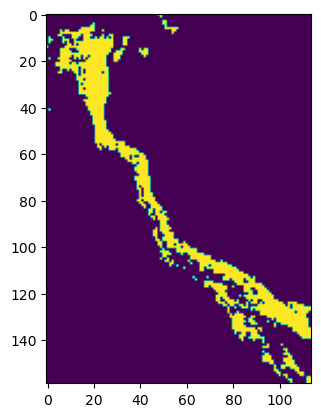

In [ ]:
plt.imshow(raster)

In [ ]:
cipher = {"Reef": 1}

In [ ]:
import gdal

ModuleNotFoundError: No module named 'gdal'

In [ ]:
# extent = load_gpkg("/Users/orlandotimmerman/Downloads/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Reef-Extent/reefextent.gpkg")
benthic = load_gpkg("/Users/orlandotimmerman/Downloads/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Benthic-Map/benthic.gpkg")

In [ ]:
benthic.to_file("/Users/orlandotimmerman/Downloads/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Benthic-Map/benthic.shp")

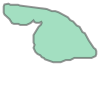

In [ ]:
extent.geometry.iloc[0]

In [ ]:
from matplotlib.collections import PolyCollection
import matplotlib
from shapely import geometry
import shapely.ops as so

In [ ]:
poly_collection = geometry.MultiPolygon(list(extent.geometry))

In [ ]:
new_shape = so.unary_union(poly_collection)


In [ ]:
new_shape

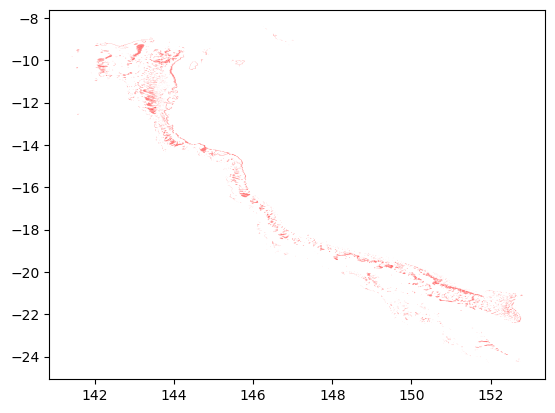

In [ ]:
fig, axs = plt.subplots()

for geom in new_shape.geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=0.5, fc='r', ec='none')

TypeError: object of type 'Polygon' has no len()

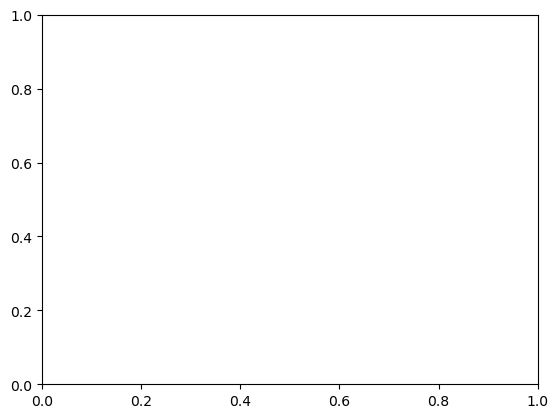

In [ ]:
fig, ax = plt.subplots()
coll = PolyCollection(extent.geometry, cmap=matplotlib.cm.jet)

In [ ]:
# # save the map
# m.save('your_map.html')

In [ ]:
# import folium
# import geopandas as gpd


# gpd_all_reef_areas = gpd.GeoDataFrame(all_reef_areas, 
# 	geometry=gpd.points_from_xy(all_reef_areas.lng, all_reef_areas.lat))


# test_map = folium.Map(location=[gpd_all_reef_areas.centroid.y.mean(), gpd_all_reef_areas.centroid.x.mean()], zoom_start=1)
# # create a folium GeoJson object from the geopandas dataframe
# geojson_lim = folium.GeoJson(gpd_all_reef_areas[:1000].__geo_interface__)
# geojson_lim.add_to(test_map)
# display(test_map)


In [ ]:
baseline_datasets_data_dir = Path('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/reef_baseline/RR_contemporary/tabular-data')
df_list = []
for area_file in baseline_datasets_data_dir.rglob("seaviewsurvey_reefcover_*.csv"):
	# read file and save as pkl to correct folder, with standardised formatting (e.g. save 'lng' as 'lon', speci)
	df_list.append(pd.read_csv(area_file))

In [ ]:
# # data_path = Path('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/reef_baseline/tabular-data/seaviewsurvey_annotations.csv')

# # load in csv files with names seaviewsurvey_reefcover_AREA
# # plot lat/lon points as particular colour for area (potentially conusing cartopy)
# atlantic_data_path = Path(''/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/reef_baseline/tabular-data/seaviewsurvey_reefcover_atlantic.csv'')
# atlantic_data = pd.read_csv(atlantic_data_path)
# atlantic_data.head()

In [ ]:
# len(all_reef_areas)

In [ ]:
# fig = plt.figure(figsize=(12, 6), dpi=300)
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# # Add a global map background
# # ax.stock_img()

# ax.scatter(all_reef_areas.lng, all_reef_areas.lat, s=1, color='coral', transform=ccrs.PlateCarree())


# ax.add_feature(cfeature.LAND.with_scale("10m"))
# ax.add_feature(cfeature.OCEAN.with_scale("10m"))

# xticks = np.arange(-180, 190, 10)
# yticks = np.arange(-90, 100, 10)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# # Set x-label and y-label
# ax.set_xlabel(r"Longitude (°)", fontsize=12)
# ax.set_ylabel(r"Latitude (°)", fontsize=12)
# ax.grid(color='grey', which='both', alpha=0.5)

# # ax.set_ylim(18, 23)
# # ax.set_xlim(-162, -154)
# # Hawaii'i
# # ax.set_ylim(19, 20.2)
# # ax.set_xlim(-156.1, -155.8)
# # Caribbean
# # Coral triangle
# # ax.set_ylim(-30, 10)
# # ax.set_xlim(110, 160)
# # # North Sulawesi
# # ax.set_ylim(0, 10)
# # ax.set_xlim(120, 130)
# plt.xticks(rotation=45)

# plt.show()

In [ ]:
# import folium
# import geopandas as gpd

# # # load data into geopandas dataframe
# # data = gpd.read_file('your_data_file.geojson')

# gpd_all_reef_areas = gpd.GeoDataFrame(all_reef_areas, 
# 	geometry=gpd.points_from_xy(all_reef_areas.lng, all_reef_areas.lat))

# # convert the geometry column to EPSG 4326 (WGS84)
# # data = gpd_all_reef_areas.to_crs(epsg=4326)

# # create a folium map object
# m = folium.Map(location=[gpd_all_reef_areas.centroid.y.mean(), gpd_all_reef_areas.centroid.x.mean()], zoom_start=10)

# # create a folium GeoJson object from the geopandas dataframe
# geojson = folium.GeoJson(gpd_all_reef_areas.__geo_interface__)

# # add the GeoJson object to the map
# geojson.add_to(m)

# # save the map
# # m.save('your_map.html')
